In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from statistics import mean, stdev
import seaborn as sns
import matplotlib
import random

from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
G = nx.read_edgelist("senzaUno.csv", delimiter = ',', create_using = nx.DiGraph)

In [3]:
df = pd.read_csv('senzaUno.csv', names = ['node_1', 'node_2'])
df.head()

,node_1,node_2
0,A,B
1,7364,3512
2,13728,704
3,10222,17618
4,10222,1784


In [4]:
# creo una lista di nodi 
node_1 = df["node_1"]
node_2 = df["node_2"]

In [6]:
# la funzione ci permetterà di ottenere le connected components
def connected_component_subgraphs(G):             
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [7]:
dfCut = pd.DataFrame({'node_1': node_1, 'node_2': node_2})

In [8]:
# creiamo il grafo utilizzando le liste contenenti un numero ridotto di nodi
G = nx.from_pandas_edgelist(dfCut, "node_1", "node_2", create_using = nx.Graph())

In [9]:
# creiamo un grafo composto soltanto da connected components
Gc = max(connected_component_subgraphs(G), key = len)

In [10]:
nx.number_connected_components(Gc)

1

In [11]:
# creiamo una lista di nodi da Gc
node_list = list(Gc.nodes)

In [13]:
# costruiamo la adjacency matrix
adj_G2 = nx.adjacency_matrix(Gc,nodelist = node_list)

In [15]:
adj_G2.shape

(5848, 5848)

In [16]:
# otteniamo le coppie di nodi unconnected
all_unconnected_pairs = []

# attraversiamo la adjacency matrix
offset = 0
for i in tqdm(range(adj_G2.shape[0])):
      for j in range(offset,adj_G2.shape[1]):
        if i != j:
            if nx.shortest_path_length(Gc,node_list[i],node_list[j]) <=2:
                if adj_G2[i,j] == 0:
                      all_unconnected_pairs.append([node_list[i],node_list[j]])

        offset = offset + 1

100%|███████████████████████████████████████████████████████████████████████████| 5848/5848 [00:00<00:00, 10905.25it/s]


In [17]:
len(all_unconnected_pairs)

1932

In [18]:
#creiamo liste di nodi unconnected
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

#creiamo un dataframe  
data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

#aggiungiamo target variable 'link', 0 perché non sono connessi
data['link'] = 0

data.head()

,node_1,node_2,link
0,7364,13728,0
1,7364,704,0
2,7364,10222,0
3,7364,17618,0
4,7364,2501,0


In [19]:
#lista di edges in Gc, costruita come una lista di tuple
lista = list(Gc.edges())
len(lista)

42579

In [20]:
len(Gc.edges())

42579

In [21]:
dfCon = pd.DataFrame(lista, columns = ['node_1', 'node_2'])

In [22]:
initial_node_count = len(Gc.nodes)

df_temp = dfCon.copy()

# lista vuota per allocare i link rimovibili
omissible_links_index = []

for i in tqdm(dfCon.index.values):
  
      # rimuove le coppie di nodi e costruisce un nuovo grafo
      G_temp = nx.from_pandas_edgelist(df_temp.drop(index = i), "node_1", "node_2", create_using = nx.Graph())
  
      # controlliamo che non ci sia stata una scissione del grafo e che il numero dei nodi sia uguale
      if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
            omissible_links_index.append(i)
            df_temp = df_temp.drop(index = i)

100%|████████████████████████████████████████████████████████████████████████████| 42579/42579 [39:03<00:00, 18.17it/s]


In [23]:
len(omissible_links_index)

36732

In [24]:
# creiamo un dataframe di edges rimovibili
df_ghost = dfCon.loc[omissible_links_index]

# aggiungo il target variable 'link'
df_ghost['link'] = 1

data = data.append(df_ghost[['node_1', 'node_2', 'link']], ignore_index = True)

In [25]:
data['link'].value_counts()

1    36732
0     1932
Name: link, dtype: int64

In [26]:
# elimino gli edges rimovibili
df_partial = dfCon.drop(index = df_ghost.index.values)

# costruisco il grafo
G_data = nx.from_pandas_edgelist(df_partial, "node_1", "node_2", create_using = nx.Graph())

In [30]:
from node2vec import Node2Vec

# Generiamo walks
node2vec = Node2Vec(G_data, dimensions = 100, walk_length = 16, num_walks = 50)

# train node2vec model
n2w_model = node2vec.fit(window = 7, min_count = 1)

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 50/50 [02:50<00:00,  3.42s/it]


In [31]:
# applico il modello su ogni coppia di nodi 
x = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]

<ipython-input-31-0f0c59199ebc>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  x = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]


In [32]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

In [33]:
lr = LogisticRegression(class_weight = "balanced")

lr.fit(xtrain, ytrain)

LogisticRegression(class_weight='balanced')

In [34]:
predictions = lr.predict_proba(xtest)

In [35]:
roc_auc_score(ytest, predictions[:,1])

0.9646234719823271

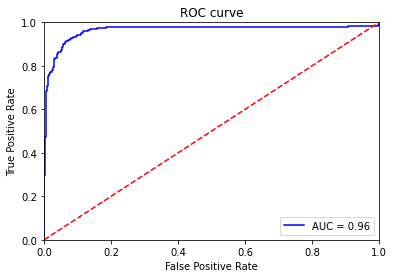

In [36]:
import sklearn.metrics as metrics

preds = predictions[:,1]
fpr, tpr, threshold = metrics.roc_curve(ytest, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()